In [3]:
%pip install tensorflow opencv-python mediapipe scikit-learn matplotlib pandas pyarrow wandb plotly tqdm

/usr/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/2a/14/e75e52d521442e2fcc9f1df3c5e456aead034203d4797867980de558ab34/tqdm-4.66.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 10.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import math
import pandas as pd
import numpy as np
#Load parquet data into dataset_parquet for training.
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2
from glob import glob
from tqdm import tqdm
from collections import Counter
import random
import time
import wandb

In [5]:
class CONFIG:
    # root = os.path.join("/", "kaggle", "input", "asl-signs") 
    root = os.path.join(".")
    DATA_LIMIT = 100
    BATCH_SIZE = 8
    VIDEO_LENGTH = 60
    TRAIN_VAL_SPLIT = 0.9
    WANDB_RUN = "mediapipe-asl-dataset"


In [6]:
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

EYE_LEFT = np.array([33, 7, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 471, 470, 469, 472])
EYE_RIGHT = np.array([362, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382, 476, 475, 474, 477])
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])

print("LIPS : ",len(LIPS_IDXS0))
print("EYE_LEFT : ",len(EYE_LEFT))
print("EYE_RIGHT : ",len(EYE_RIGHT))
print("LEFT_HAND : ",len(LEFT_HAND_IDXS0))
print("RIGHT_HAND : ",len(RIGHT_HAND_IDXS0))
print("LEFT_POSE : ",len(LEFT_POSE_IDXS0))
print("RIGHT_POSE : ",len(RIGHT_POSE_IDXS0))

all_selection = np.concatenate([LIPS_IDXS0, EYE_LEFT, EYE_RIGHT, LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0, LEFT_POSE_IDXS0, RIGHT_POSE_IDXS0])
print(len(all_selection))

LIPS :  40
EYE_LEFT :  20
EYE_RIGHT :  20
LEFT_HAND :  21
RIGHT_HAND :  21
LEFT_POSE :  5
RIGHT_POSE :  5
132


In [7]:
#this code sorts out a parquet files and rearrange the order to pose,face, left-hand, right-hand
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly.graph_objs as go
import plotly.io as pio

ids = None

order_global = {"pose" : 10000, "face" : 1000, "left_hand" : 100, "right_hand" : 10}

def visualize_keypoints(frames : np.ndarray, point_size : int):
    if len(frames.shape) == 1:
        frames = np.array([frames])
    
    for frame in frames:
        frame = frame.reshape(-1, 3)
        sizes = point_size * np.ones(frame.shape[0])

        fig = go.Figure(data=go.Scatter(x=frame[:,0], y=2.5 - frame[:,1], mode='markers',
                                        marker=dict(
                                            size=sizes
                                            )))

    # Customize the layout
    fig.update_layout(title='visualization of human keypoints',
                        xaxis_title='',
                        yaxis_title='',
                        width=1000,
                        height=1600)

    fig.update_xaxes(range=[-0.2, 1.4])  # Set x-axis range from 0 to 6
    fig.update_yaxes(range=[0, 2.5])  # Set y-axis range from 10 to 20

    # Show the plot
    fig.show()


def process_parquet(ds, idxes = None):
    ret = []
    frames_unique = sorted(np.unique(ds["frame"]))
    for i,frame in enumerate(frames_unique):
        frame_ds = ds[ds['frame'] == frame]
        
        order = []
        for el in frame_ds["row_id"]:
            _frame, part, keypoint = el.split("-")
            order.append(order_global[part] - int(keypoint))

        order = np.array(order)
        frame_ds.iloc[:, 1] = order
        frame_ds = frame_ds.sort_values(by="row_id", ascending=False)
    
        vals = np.array(frame_ds[["x", "y", "z"]])
        if idxes is not None:
            vals = vals[idxes]
    
        vals = vals.flatten()

        ret.append(vals)
        
    return np.array(ret)


def process_parquet2(ds, idxes = None):
    ret = []    
    frame_size = 543
    it = len(ds) // frame_size
    assert it == len(ds) / frame_size
    
    for i in range(it):
        vals = ds.iloc[ i * frame_size : (i + 1 ) * frame_size ]        
        
        if idxes is not None:          
            vals = ds.iloc[idxes]
                        
        ret.append(np.array(vals[["x","y", "z"]]).flatten())
        
    return np.array(np.array(ret))

In [8]:
f = process_parquet(pd.read_parquet("79631423.parquet"))
visualize_keypoints(f[0], point_size=10)

FileNotFoundError: [Errno 2] No such file or directory: '79631423.parquet'

In [ ]:
f2 = process_parquet2(pd.read_parquet("79631423.parquet"), idxes=all_selection)
visualize_keypoints(f2[0], point_size=10)

In [9]:
df = pd.read_parquet( os.path.join("..", "data","ASL-ds", "train_landmark_files", "16069", "695046.parquet"))

FileNotFoundError: [Errno 2] No such file or directory: '../data/ASL-ds/train_landmark_files/16069/695046.parquet'

In [11]:
from sklearn.model_selection import train_test_split

#custom class to load data from Parquet files for training ML models.
class ParquetDataset(keras.utils.Sequence):
    def __init__(self, dataset_folder, csv_file : str, batch_size=CONFIG.BATCH_SIZE, 
                 data_limit :int= CONFIG.DATA_LIMIT, check_if_file_exists = True, 
                 preprocessing_func=None, frame_length :int = CONFIG.VIDEO_LENGTH,
                 split : str = "train", train_val_split : float = CONFIG.TRAIN_VAL_SPLIT,
                 sort_by_counts : bool = True, **kwargs
                ):
        super().__init__(**kwargs)
        #taking keras sequence for .fit(), .evaluate(), .predict() methods
        #load csv - it has the path to parquet file, and another to store label
        self.csv_path = csv_file
        self.root_folder = dataset_folder
        self.batch_size = batch_size
        #optional pre-processing function to the parquet files.
        self.preprocessing_func = preprocessing_func
        
        self.csv_data = pd.read_csv(self.csv_path)
        
        self.all_files = []
        self.not_exists = []
        self.frame_length = frame_length

        
        for path, label in tqdm(list(zip(self.csv_data["path"], self.csv_data["sign"]))):
            prop_path = os.path.join(self.root_folder, path)
            
            if check_if_file_exists:
                if os.path.exists(prop_path):
                    self.all_files.append((prop_path, label))
                else:
                    self.not_exists.append(prop_path)
            else:
                self.all_files.append((prop_path, label))
                
                    
        self.all_files = np.array(self.all_files)
        self.unique_labels = np.unique(self.all_files[:, 1])
        self.label_2_id = { key : i for i, key in enumerate(self.unique_labels)}
    
        # sort the values by popularity
        if sort_by_counts:
            cnt = Counter(self.all_files[:, 1])
            vals = []
            
            for i,row in enumerate(self.all_files):
                vals.append((int(1e6 * cnt[row[1]] + self.label_2_id [row[1]]),i))
            
            vals = np.array(sorted(vals)[::-1])
            self.all_files = self.all_files[vals[:,1]]

        
        if data_limit < 0:
            train_ds, val_ds = train_test_split(self.all_files, train_size=train_val_split, random_state=42)
        else:
            train_ds, val_ds = train_test_split(self.all_files[:data_limit], train_size=train_val_split, random_state=42)
            self.unique_labels = np.unique(self.all_files[:data_limit, 1])
            self.label_2_id = { key : i for i, key in enumerate(self.unique_labels)}
            
        if split.lower() == "train":
            self.dataset = train_ds
            
        elif split.lower() == "val":
            self.dataset = val_ds 
            
        else:
            raise Exception("please specify split to be either train or val")
            
        np.random.shuffle(self.dataset)
                   

    def __len__(self):
        # Assuming each Parquet file should be one batch; adjust if necessary
        return math.ceil(len(self.dataset) / self.batch_size)
    
    def get_single(self, idx):
        # Load one file per batch
        #take the idx value, 1st label, 
        path, label = self.dataset[idx]
        
        df = pd.read_parquet( path)
        
        # Apply preprocessing if specified
        if self.preprocessing_func:
            df = self.preprocessing_func(df, self.frame_length)
        
        one_hot_encoded_label = np.zeros(len(self.unique_labels))
        one_hot_encoded_label[self.label_2_id[label]] = 1  
        
        return df, one_hot_encoded_label

    def __getitem__(self, idx):
        X, Y = [], []
        
        low = idx * self.batch_size
        high = min(low + self.batch_size, len(self.dataset))
        
        for i in range(low, high):
            x, y = self.get_single(i)
            X.append(x)
            Y.append(y)
        
        return np.array(X), np.array(Y)
                
        
    def on_epoch_end(self):
        # Shuffle files for the next epoch
        np.random.shuffle(self.dataset)

def my_preprocessing_func(df, frame_length):
    
    # Define your preprocessing steps here
    # Example: normalize numerical features
    frames_mediapipe = process_parquet2(df, all_selection)
    
    current_length, num_features = frames_mediapipe.shape

    if current_length >= frame_length:
            # TODO: a better than uniform value ? Could place gaussian in the middle
            random_start = random.randint(0, current_length - frame_length)
            return np.nan_to_num(frames_mediapipe[random_start : (random_start + frame_length)])
        
    # padd the video to contain zeros 
    return np.concatenate([np.nan_to_num(frames_mediapipe), np.zeros((frame_length - current_length, num_features))], axis=0)
    
# Usage example
parquet_folder_path = CONFIG.root
train_dataset_parquet = ParquetDataset(parquet_folder_path, csv_file = os.path.join(CONFIG.root, "train.csv"), 
                                 batch_size=CONFIG.BATCH_SIZE, data_limit=1000,
                                 preprocessing_func=my_preprocessing_func,
                                check_if_file_exists = True,
                                split="train")

val_dataset_parquet = ParquetDataset(parquet_folder_path, csv_file = os.path.join(CONFIG.root, "train.csv"), 
                                 batch_size=CONFIG.BATCH_SIZE, data_limit=1000,
                                 preprocessing_func=my_preprocessing_func,
                                 check_if_file_exists= True,
                                 split="val")

print(f"cardinality of train : {len(train_dataset_parquet)}, cardinality of validation : {len(val_dataset_parquet)}")

100%|██████████| 94477/94477 [00:00<00:00, 315050.58it/s]


cardinality of train : 113, cardinality of validation : 13


In [19]:
NUM_FEATURES = train_dataset_parquet[0][0].shape[-1]

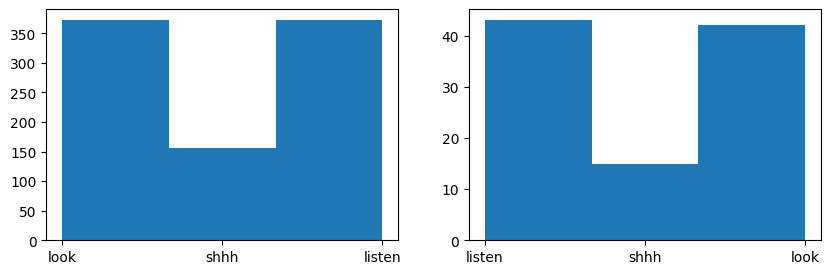

In [12]:
import matplotlib.pyplot as plt 


plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.hist(train_dataset_parquet.dataset[:, 1], bins=len(train_dataset_parquet.unique_labels))

plt.subplot(1, 2, 2)
plt.hist(val_dataset_parquet.dataset[:, 1], bins=len(val_dataset_parquet.unique_labels))

plt.show()

In [19]:
start = time.time()
isnans =False

f = True
labels_batches = []
for el in tqdm(train_dataset_parquet):
    if f:
        print(el[0].shape, el[1].shape)
        f = False
    labels_batches.append(el[1])
        
    isnans |= np.any(np.isnan(el[0]))
    if isnans:
        print("FOUND NAN!")
        break


print(f"Iterating through dataset took : {round( time.time() - start , 4)}s")

  1%|          | 1/113 [00:00<00:21,  5.19it/s]

(8, 60, 396) (8, 3)


100%|██████████| 113/113 [00:20<00:00,  5.40it/s]

Iterating through dataset took : 20.9304s


# Train experiment

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from wandb.keras import WandbMetricsLogger
from keras.callbacks import Callback
import tensorflow as tf
import wandb


class CosineAnnealingLearningRateScheduler(Callback):
    def __init__(self, max_lr, min_lr, T_max):
        super(CosineAnnealingLearningRateScheduler, self).__init__()
        self.max_lr = max_lr  # Maximum learning rate (i.e., start learning rate)
        self.min_lr = min_lr  # Minimum learning rate
        self.T_max = T_max    # Specifies the number of epochs per cycle
        self.t = 0            # Current epoch

    def on_epoch_begin(self, epoch, logs=None):
        self.t += 1
        cos = np.cos(np.pi * (self.t % self.T_max) / self.T_max)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + cos)

        keras.backend.set_value(self.model.optimizer.lr, lr)

def keras_train(model, filepath : str, max_lr = 1e-4, min_lr = 5e-5, T_max=50, epochs=100, run_name="",
                mediapipe_features = "all", USE_WANDB=True): 
    
    
    checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                                 monitor="val_categorical_accuracy",
                                                 verbose=0,
                                                 save_best_only=True,
                                                 mode="max",
                                                 save_freq="epoch")
    
    cosine_annealer = CosineAnnealingLearningRateScheduler(max_lr=max_lr,
                                                           min_lr=min_lr,
                                                           T_max=T_max)
    
    #Adam Optimizer - fixed learning rate.
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=max_lr, clipnorm=1.)

    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    
    callbacks  = [checkpoint, cosine_annealer]
    
    if USE_WANDB:
        wandb.init(project=CONFIG.WANDB_RUN,
                        name=run_name,
                        notes="Model summary : \n" + str(model),
                        config={"max_lr" : max_lr, 
                                "min_lr" : 5e-5, 
                                "scheduler" : "cosineAnnealer", 
                                "epochs" : epochs, 
                                "T_max" : T_max, 
                                "train_size" : len(train_dataset_parquet.dataset),
                                "val_size" : len(val_dataset_parquet.dataset),
                                "unique_classes" : len(train_dataset_parquet.unique_labels), 
                                "video_length" : CONFIG.VIDEO_LENGTH,
                                "features" : mediapipe_features
                                })
        callbacks.append(WandbMetricsLogger())


    history = model.fit(train_dataset_parquet, epochs=epochs, validation_data = val_dataset_parquet, 
                        batch_size = 8, callbacks=callbacks)
    
    if USE_WANDB:      
        wandb.finish()
    
    return history

# Train simple LSTM

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 396),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "LSTM1.tf"),
            run_name="LSTM128-Dense128-Dense256-LipsEyesHandsPose",
           mediapipe_features="LipsEyesHandsPose")

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, NUM_FEATURES),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF={NUM_FEATURES}.tf"),
            run_name="LSTM64-Dense128-Dense256-LipsEyesHandsPose")

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(256, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF={NUM_FEATURES}.tf"),
            run_name=f"LSTM256-Dense128-Dense256-allfeatures")

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, NUM_FEATURES),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"LSTM128-Dense256-LipsEyesHandsPose_NF={NUM_FEATURES}.tf"),
            run_name="LSTM128-Dense256-LipsEyesHandsPose")

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"LSTM128-Dense256-LipsEyesHandsPose_NF={NUM_FEATURES}.tf"),
            run_name="LSTM128-Dense128-LipsEyesHandsPose")

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, NUM_FEATURES),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"LSTM128-Dense256-LipsEyesHandsPose_NF={NUM_FEATURES}.tf"),
            run_name="LSTM128-Dense256-LipsEyesHandsPose")

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, activation='relu', input_shape=(CONFIG.VIDEO_LENGTH, NUM_FEATURES),
               kernel_regularizer=l2(0.0000001), 
               activity_regularizer=l2(0.0000001)))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF={NUM_FEATURES}.tf"),
            run_name="LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose")

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, NUM_FEATURES),
               kernel_regularizer=l2(0.005), 
               activity_regularizer=l2(0.005)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"LSTM-L64-D128-D256-reg=0.005-LipsEyesHandsPose_NF={NUM_FEATURES}.tf"),
            run_name="LSTM64-Dense128-Dense256-LipsEyesHandsPose_bigger_reg")

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, NUM_FEATURES),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"LSTM128-Dense128-Dense256-LipsEyesHandsPose_NF={NUM_FEATURES}.tf"),
            run_name="LSTM128-Dense128-Dense256-LipsEyesHandsPose")

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, NUM_FEATURES),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"LSTM64-Dense64-LipsEyesHandsPose_NF={NUM_FEATURES}.tf"),
            run_name="LSTM64-Dense64-LipsEyesHandsPose_NF", T_max=75, epochs=100, 
            max_lr = 1e-4, min_lr = 2.5e-5)

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, NUM_FEATURES),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"LSTM64-Dense128-LipsEyesHandsPose_NF={NUM_FEATURES}.tf"),
            run_name="LSTM64-Dense128-LipsEyesHandsPose", T_max=75, epochs=100, 
            max_lr = 1e-4, min_lr = 2.5e-5)

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, NUM_FEATURES),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"LSTM64-Dense256-LipsEyesHandsPose_NF={NUM_FEATURES}.tf"),
            run_name="LSTM64-Dense256-LipsEyesHandsPose", T_max=75, epochs=100, 
            max_lr = 1e-4, min_lr = 2.5e-5)

# Transformer

In [12]:
import tensorflow
print(tensorflow.__version__)

2.14.0


In [23]:
x, y = train_dataset_parquet[0]
print(x.shape)

(8, 60, 1629)


In [39]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

class PositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(PositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=embed_dim, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        print(x.shape, positions.shape)
        return x + positions

In [51]:
# Create a single transformer encoder layer.
encoder = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=64, num_heads=8)

# Create a simple model containing the encoder.
input = keras.Input(shape=(10, 64))
output = encoder(input)
model = keras.Model(inputs=input, outputs=output)

# Call encoder on the inputs.
input_data = np.random.uniform(size=(2, 10, 64))
output = model(input_data)

NameError: name 'keras_nlp' is not defined

In [21]:
x.shape

(8, 60, 1629)